<a href="https://colab.research.google.com/github/Logadharshin/Cryptodynamic-Oscillation-Projection-Via-Algorithmic-Paradigm/blob/main/MAIN_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scikit-learn tensorflow

**LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load the dataset
df = pd.read_csv('/content/1000_cryptos.csv')

# Filter data for a specific cryptocurrency (e.g., Bitcoin)
crypto_symbol = 'BTC-USD'
df = df[df['symbol'] == crypto_symbol]

# Convert 'dates' column to datetime
df['dates'] = pd.to_datetime(df['dates'])

# Sort by date
df = df.sort_values('dates')

# Use 'close' price for prediction
data = df['close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a function to create sequences of data
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 60

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

# Reshape X to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

<ipython-input-3-3e9223ba37d3>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dates'] = pd.to_datetime(df['dates'])


**LOADING DATASET**

In [ ]:
crypto = pd.read_csv('/content/1000_cryptos.csv')
crypto

,dates,symbol,open,close,high,low,volume,adj_close
0,2021-04-10 00:00:00,DPR-USD,0.079098,0.146272,0.148062,0.078830,33999748.0,0.146272
1,2021-04-11 00:00:00,DPR-USD,0.146276,0.282001,0.291825,0.146276,44714719.0,0.282001
2,2021-04-12 00:00:00,DPR-USD,0.281985,0.263512,0.334116,0.259679,19434610.0,0.263512
3,2021-04-13 00:00:00,DPR-USD,0.260683,0.224074,0.339955,0.215612,19072259.0,0.224074
4,2021-04-14 00:00:00,DPR-USD,0.224068,0.209763,0.239094,0.205782,11615385.0,0.209763
...,...,...,...,...,...,...,...,...
855617,2023-11-22 00:00:00,USDJ-USD,1.126903,1.127983,1.129865,1.124683,1240835.0,1.127983
855618,2023-11-23 00:00:00,USDJ-USD,1.128227,1.126813,1.128888,1.125329,1273455.0,1.126813
855619,2023-11-24 00:00:00,USDJ-USD,1.126986,1.127946,1.128529,1.125137,1185029.0,1.127946
855620,2023-11-25 00:00:00,USDJ-USD,1.127748,1.128468,1.130797,1.125809,1140274.0,1.128468


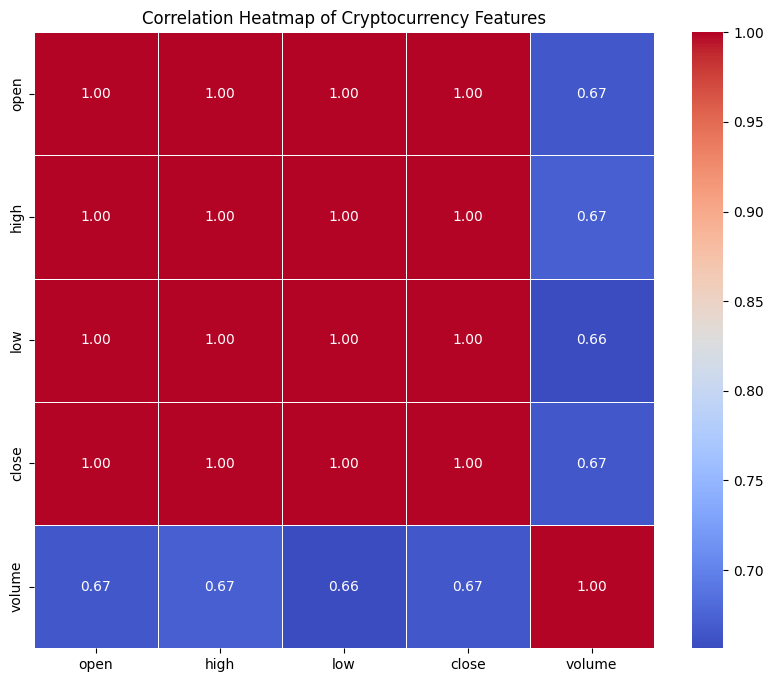

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt # Import matplotlib.pyplot

# Calculate correlation matrix
corr = df[['open', 'high', 'low', 'close', 'volume']].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap of Cryptocurrency Features')
plt.show()

**BUILD THE LSTM MODEL**

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X, y, batch_size=1, epochs=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3639/3639 ━━━━━━━━━━━━━━━━━━━━ 161s 43ms/step - loss: 0.0027


**PREDICTED PRICE**

In [ ]:
# Get the last sequence of data
last_sequence = scaled_data[-seq_length:]
last_sequence = np.reshape(last_sequence, (1, seq_length, 1))

# Predict the next value
predicted_price = model.predict(last_sequence)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted Price: {predicted_price[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
Predicted Price: 99437.84375


**ACTUAL Vs PREDICTED PRICE**

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

# Make predictions on the training data #This was moved up so y_actual and train_predict are defined
train_predict = model.predict(X)
train_predict = scaler.inverse_transform(train_predict)
y_actual = scaler.inverse_transform(y.reshape(-1, 1))

# Create a DataFrame for actual and predicted prices
results_df = pd.DataFrame({
    'Date': df['dates'][seq_length:],
    'Actual Price': y_actual.flatten(),
    'Predicted Price': train_predict.flatten()
})

# Plot using Plotly
fig = go.Figure()

# Add actual price trace
fig.add_trace(go.Scatter(
    x=results_df['Date'],
    y=results_df['Actual Price'],
    mode='lines',
    name='Actual Price',
    line=dict(color='blue')
))

# Add predicted price trace
fig.add_trace(go.Scatter(
    x=results_df['Date'],
    y=results_df['Predicted Price'],
    mode='lines',
    name='Predicted Price',
    line=dict(color='red', dash='dash'))
)

# Update layout
fig.update_layout(
    title=f'{crypto_symbol} Actual vs. Predicted Prices',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    hovermode='x unified',
    template='plotly_dark'  # Use a dark theme for better aesthetics
)

fig.show()

114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


**CALCULATE MSE, MAE, and R²**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions on the training data
train_predict = model.predict(X)
train_predict = scaler.inverse_transform(train_predict)
y_actual = scaler.inverse_transform(y.reshape(-1, 1))

# Calculate MSE, MAE, and R²
mse = mean_squared_error(y_actual, train_predict)
mae = mean_absolute_error(y_actual, train_predict)
r2 = r2_score(y_actual, train_predict)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared (R²): {r2}")

114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Mean Squared Error: 3261761.959531002
Mean Absolute Error: 1329.937900967767
R-squared (R²): 0.9942308456824878


**MOVING AVERAGES**

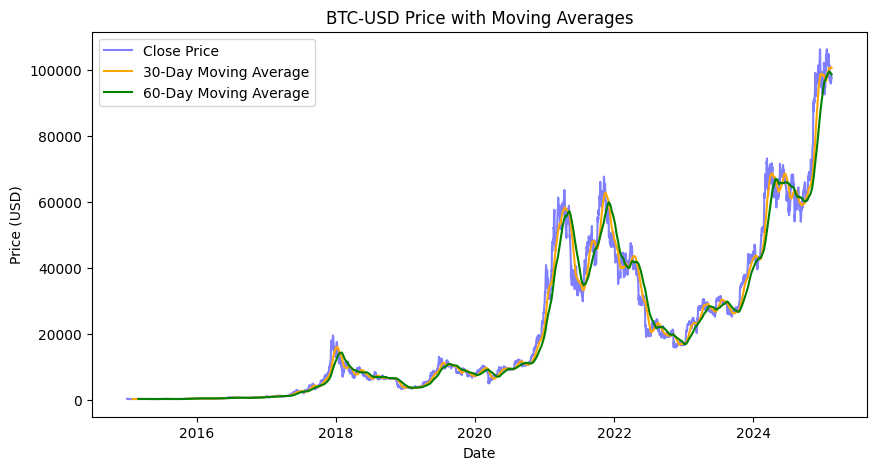

In [ ]:
df['MA_30'] = df['close'].rolling(window=30).mean()  # 30-day moving average
df['MA_60'] = df['close'].rolling(window=60).mean()  # 60-day moving average

# Plot moving averages
plt.figure(figsize=(10, 5))
plt.plot(df['dates'], df['close'], label='Close Price', color='blue', alpha=0.5)
plt.plot(df['dates'], df['MA_30'], label='30-Day Moving Average', color='orange')
plt.plot(df['dates'], df['MA_60'], label='60-Day Moving Average', color='green')
plt.title(f'{crypto_symbol} Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
model.save(f'{crypto_symbol}_lstm_model.h5')

**FUTURE PREDICTION**

In [ ]:
from tensorflow.keras.models import load_model #Import load_model to load saved model

# Load the model
model = load_model(f'{crypto_symbol}_lstm_model.h5')

# Re-initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
#Re-fit the scaler
scaler.fit(data)

# Get the last sequence of data, must do this again because it may have changed when the kernel is reset
last_sequence = scaled_data[-seq_length:]
last_sequence = np.reshape(last_sequence, (1, seq_length, 1))

# Initialize current_sequence with last_sequence before predicting
current_sequence = last_sequence

# Predict future prices
future_predictions = []

for _ in range(30):  # Predict for the next 30 days
    next_prediction = model.predict(current_sequence)
    future_predictions.append(scaler.inverse_transform(next_prediction)[0][0])
    #append the prediction to the sequence and remove the first item in the sequence
    current_sequence = np.append(current_sequence[:,1:,:],next_prediction.reshape(1,1,1),axis=1)


print(f"Future Predictions: {future_predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━

**PLOT DISTRIBUTION**

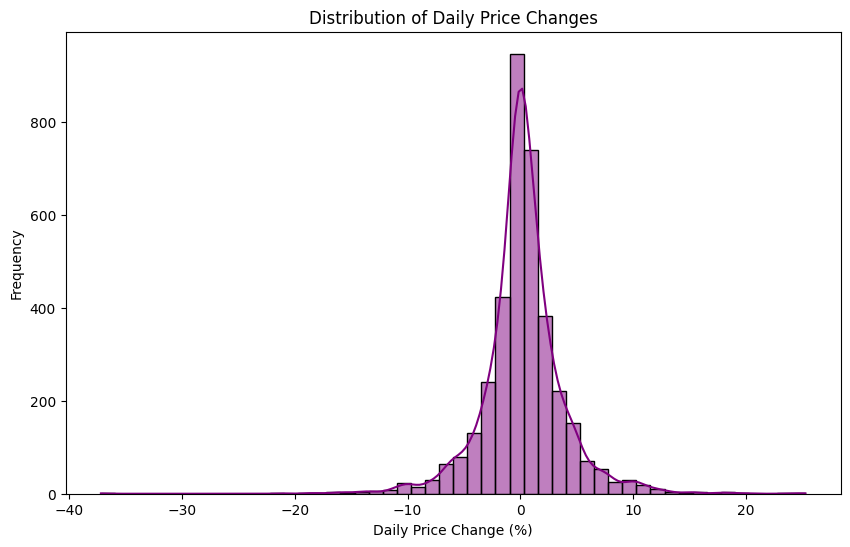

In [ ]:
# Calculate daily price changes
df['Price Change'] = df['close'].pct_change() * 100

# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Price Change'].dropna(), kde=True, color='purple', bins=50)
plt.title('Distribution of Daily Price Changes')
plt.xlabel('Daily Price Change (%)')
plt.ylabel('Frequency')
plt.show()

In [ ]:

# Import the necessary library
import pandas as pd

# Generate future dates starting from the last date in your original DataFrame
from datetime import timedelta  # Import timedelta for date calculations

# Calculate the last date in your original DataFrame
last_date = df['dates'].iloc[-1]

# Generate future dates (e.g., for 30 days)
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30, freq='D')

future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price': future_predictions
})

**PLOT FOR FUTURE PRICE PREDICTION**

In [ ]:
# Create a DataFrame for future predictions
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price': future_predictions
})

# Plot using Plotly
fig = go.Figure()

# Add future predictions trace
fig.add_trace(go.Scatter(
    x=future_df['Date'],
    y=future_df['Predicted Price'],
    mode='lines+markers',
    name='Future Predictions',
    line=dict(color='green'),
    marker=dict(size=8))
)

# Add confidence interval (example: ±5% of predicted price)

fig.add_trace(go.Scatter(
    x=future_df['Date'],
    y=future_df['Predicted Price'] * 1.05,
    mode='lines',
    name='Upper Bound',
    line=dict(width=0),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=future_df['Date'],
    y=future_df['Predicted Price'] * 0.95,
    mode='lines',
    name='Lower Bound',
    line=dict(width=0),
    fillcolor='rgba(0, 100, 80, 0.2)',
    fill='tonexty',
    showlegend=False
))

# Update layout
fig.update_layout(
    title=f'{crypto_symbol} Future Price Predictions',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    hovermode='x unified',
    template='plotly_dark'
)

fig.show()

**3D SURFACE PLOT**

In [ ]:
# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(
    z=df[['open', 'high', 'low', 'close']].values,
    x=df['dates'],
    y=['Open', 'High', 'Low', 'Close']
)])

# Update layout
fig.update_layout(
    title=f'{crypto_symbol} 3D Price Trends',
    scene=dict(
        xaxis_title='Date',
        yaxis_title='Price Type',
        zaxis_title='Price (USD)'
    ),
    template='plotly_dark'
)

fig.show()

**PRICE OVER TIME**

In [ ]:

# Create an animated line chart
fig = px.line(df, x='dates', y='close', title=f'{crypto_symbol} Price Over Time',
              labels={'close': 'Price (USD)', 'dates': 'Date'},
              template='plotly_dark')

# Add animation
fig.update_layout(
    xaxis=dict(rangeslider=dict(visible=True)),
    updatemenus=[dict(
        type='buttons',
        showactive=False,
        buttons=[dict(
            label='Play',
            method='animate',
            args=[None, dict(frame=dict(duration=500, redraw=True), fromcurrent=True)]
        )]
    )]
)

fig.show()

**BOXPLOT**

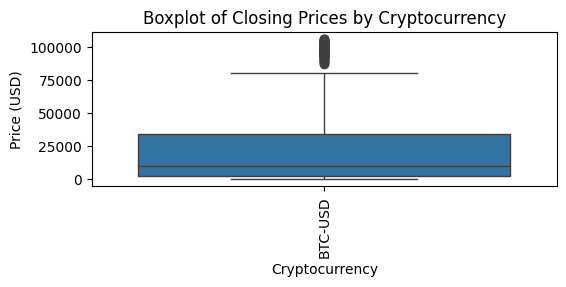

In [ ]:
9# Create a boxplot
plt.figure(figsize=(6, 2))
sns.boxplot(x=df['symbol'], y=df['close'])
plt.title('Boxplot of Closing Prices by Cryptocurrency')
plt.xlabel('Cryptocurrency')
plt.ylabel('Price (USD)')
plt.xticks(rotation=90)
plt.show()